**Warning:** the classes in this notebook are no longer up-to-date with the classes defined in the '.py' files. See `flow_demo.ipynb` for example of using those. This notebook still exists as a simple example of applying normalizing flows to a 2D data set, and as an example of how to use hyperopt to search the hyperparameter space.

---

This notebook demonstrates an example of the NormalizingFlow class, and a specific implementation of the Rational Quadratic Spline Flows from https://arxiv.org/abs/1906.04032.

The NormalizingFlow class is agnostic to the architecture of the flow, it is just a wrapper for flax modules that return a tensorflow probability transformed distribution. The idea is to make instantiation, log_prob, sampling, and training easy and straightforward.

After training a flow on data and plotting the results, hyperopt is used to search the hyperparameter space.

This notebook is a test case that will later be applied to the redshift-color space.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax
from flax import nn

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from jax_nf.real_nvp import RealNVP

## Implementing the flow

First, I implement the Rational Quadratic Neural Spline coupling from https://arxiv.org/abs/1906.04032.

This is built inside a [flax module](https://flax.readthedocs.io/en/latest/notebooks/flax_guided_tour.html), using the [RationalQuadraticSpline bijector](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RationalQuadraticSpline) from tensorflow probability.

In [3]:
@nn.module
def RQNeuralSplineCoupling(x, nfeatures, hyperparams):
    """
    Rational Quadratic Neural Spline coupling Conor Durkan, Artur Bekasov, Iain Murray, 
    George Papamakarios. Neural Spline Flows, 2019. http://arxiv.org/abs/1906.04032
    
    x is the input
    nfeatures is the number of features
    hyperparams is a dictionary that should contain the following:
        - nbins is the number of spline bins. Number of knots is nbins + 1
        - cf_range_max sets the range of the splines. Outside of the range
            (-cf_range_max,+cf_range_max), the coupling is just the identity
        - cf_dim is the dimension of hidden layers in the coupling function, 
            which is a dense network
        - cf_layers is the number of layers in the coupling function
    """
    
    # unpack the hyperparameter dictionary
    nbins = hyperparams['nbins']
    cf_range_max = hyperparams['cf_range_max']
    cf_dim = hyperparams['cf_dim']
    cf_layers = hyperparams['cf_layers']
    
    # coupling function: y = cf(x)
    # we use a dense feed forward network
    # from paper: theta_i = NN(x_1:d-1)
    y = x
    for _ in range(cf_layers - 1):
        y = nn.leaky_relu(nn.Dense(y, cf_dim))
    y = nn.Dense(y, nfeatures * (3*nbins - 1))
    y = jnp.reshape(y, [-1, nfeatures, 3*nbins - 1])
    
    # pull out widths, heights, derivatives
    bin_widths, bin_heights, knot_slopes = jnp.split(y, [nbins, 2*nbins], axis=2)
    # apply transforms as listed in the paper
    bin_widths = 2 * cf_range_max * nn.softmax(bin_widths, axis=-1)
    bin_heights = 2 * cf_range_max * nn.softmax(bin_heights, axis=-1)
    knot_slopes = nn.softplus(knot_slopes)
    
    # return the rational quadratic spline coupling
    return tfb.RationalQuadraticSpline(bin_widths=bin_widths,
                                       bin_heights=bin_heights,
                                       knot_slopes=knot_slopes,
                                       range_min=-cf_range_max)

Now I build a normalizing flow using the coupling function above. The input needs to just be a dictionary that contains the hyperparameters tof the flow. This allows compatibility with the NormalizingFlow class built below.

In [4]:
@nn.module
def RQNeuralSplineFlow(hyperparams):
    """
    A Normalizing Flow using rational quadratic splines for the
    coupling layer. Returns a tensorflow probability transformed
    distribution wrapped in a flax module.
    
    Input is a dictionary of hyperparameters.
    The only required hyperparams are nfeatures and nlayers.
    """
    
    # unpack parameters from the hyperparameter dictionary
    nfeatures = hyperparams['nfeatures']
    nlayers = hyperparams['nlayers']
    
    # construct the chain of bijectors
    # each layer consists of a RQ Spline
    # followed by a permutation
    
    # first scale up by factor of 10
    # not sure why - this was done in Francois' original notebook
    # but it definitely helps performace ¯\_(ツ)_/¯
    chain = [tfb.Scale(10)]
    for i in range(nlayers):
        # each layer as a RQ spline
        spline = RQNeuralSplineCoupling.shared(name=f'spline{i+1}',
                                               hyperparams=hyperparams)
        chain.append(RealNVP(nfeatures//2, bijector_fn=spline))
        # and a permutation
        chain.append(tfb.Permute(jnp.arange(nfeatures)[::-1]))
    
    # undo the mysterious scaling
    chain.append(tfb.Scale(0.1))
    # build a bijector chain from all these layers
    chain = tfb.Chain(chain)
    
    # construct the flow
    flow = tfd.TransformedDistribution(
                    tfd.Normal(0,1),
                    bijector=chain,
                    event_shape=(nfeatures,))
    
    return flow

Class to wrap a normalizing flow such that instantiation, log_prob, sampling, and training are easy

In [5]:
class NormalizingFlow():
    """
    Wrapper class for normalizing flows.
    
    Input:
    module - a flax module that returns a tfd.TransformedDistribution object
    hyperparams - a dictionary containing the hyperparameters for whatever module
                    you're using. The only mandatory hyperparameter is 'nfeatures'
    params - the model parameters. If not provided, random parameters are generated
                    
    Methods:
    log_prob(x) - calculates the log probability that x is drawn from the
                    transformed probability distribution
    sample(n_samples, seed=0) - draws n_samples random samples from the distribution
                    seed sets the random seed.
    train(dataframe, niter=2000, batch_size=512, return_losses=False) - trains the
                    normalizing flow on the given data set (which must be in the form
                    of a pandas dataframe) and updates the model parameters. 
                    niter is the number of training iterations.
                    batch_size is the size of batches to train on. 
                    If return_losses is True, returns a list of the training losses.
    """
    
    def __init__(self, module, hyperparams, params=None):
        
        # make sure the hyperparameter dict contains nfeatures
        if 'nfeatures' not in hyperparams:
            raise KeyError('nfeatures must be in the hyperparameter dictionary')
        
        # save the hyperparameters
        self.hyperparams = hyperparams.copy()
        
        # create modules that calculate log_prob for and sample the flow
        @nn.module
        def log_prob_module(x):
            return module(hyperparams).log_prob(x)
        @nn.module
        def sampler_module(n_samples, seed):
            return module(hyperparams).sample(n_samples, seed)
        
        # if no params provided, create some random ones
        if params is None:
            dummy_input = jnp.zeros((1,hyperparams['nfeatures']))
            _, params = log_prob_module.init(jax.random.PRNGKey(0), dummy_input)
        self.params = params
            
        # create log_prob and sampler models
        self._log_prob = nn.Model(log_prob_module, params)
        self._sampler = nn.Model(sampler_module, params)
        
    def log_prob(self, x):
        return self._log_prob(x)
    
    def sample(self, n_samples, seed=0):
        return self._sampler(n_samples, jax.random.PRNGKey(seed))
    
    def train(self, dataframe, niter=2000, batch_size=512, return_losses=False, verbose=False):
        # train the normalizing flow on the data in the dataframe

        # the optimizer used for training
        optimizer = flax.optim.Adam(learning_rate=0.001).create(self._log_prob)
        
        # compile a function that does a single training step
        @jax.jit
        def train_step(optimizer, batch):

            def loss_fn(model):
                log_prob = model(batch)
                return -jnp.mean(log_prob)

            loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
            optimizer = optimizer.apply_gradient(grad)
            return loss, optimizer
        
        # loop through the training
        losses = []
        for i in range(niter):
            batch = jnp.array(dataframe.sample(n=batch_size, replace=False))
            loss, optimizer = train_step(optimizer, batch)
            losses.append(loss)
            if verbose and i % 100 == 0:
                print(loss)
        
        # update the parameters
        self._log_prob = self._log_prob.replace(params=optimizer.target.params)
        self._sampler = self._sampler.replace(params=optimizer.target.params)
        self.params = optimizer.target.params
        
        # return list of training losses if true
        if return_losses:
            return losses

## Testing the flow on data

Now let's test it!

Load the two moons data set

In [6]:
from sklearn.datasets import make_moons
import pandas as pd

In [7]:
# load moons
x, _ = make_moons(n_samples=int(1e4), noise=0.05)

# center and enlarge the moons for aesthetics
x[:,0] -= jnp.mean(x[:,0])
x[:,1] -= jnp.mean(x[:,1])
x *= jnp.array([1.5,2])

# save moons in dataframe
x = pd.DataFrame(x)

/global/common/software/lsst/users/jfc20/mydesc/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Now train a normalizing flow to resemble the moons

In [8]:
hyperparams = {'nfeatures' : 2,
               'nlayers' : 2,
               'nbins' : 8,
               'cf_range_max' : 1,
               'cf_dim' : 128,
               'cf_layers' : 2}

flow = NormalizingFlow(RQNeuralSplineFlow, hyperparams)

/global/common/software/lsst/users/jfc20/mydesc/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/common/software/lsst/users/jfc20/mydesc/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/common/software

In [9]:
batch = jnp.array(x.sample(512))
print(f'initial loss ~ {-jnp.mean(flow.log_prob(batch)):.4f}')

initial loss ~ 3.1421


In [10]:
%time losses = flow.train(x, return_losses=True, verbose=True)

3.162623
2.3776865
1.9914384
1.8762078
1.8282069
1.8393735
1.6267208
1.6411934
1.5368361
1.6539931
1.5359755
1.5693727
1.592703
1.5466552
1.5019846
1.4464111
1.532389
1.50842
1.454832
1.5156872
CPU times: user 1min 27s, sys: 5.11 s, total: 1min 32s
Wall time: 1min 19s


In [12]:
print(f'final loss ~ {-jnp.mean(flow.log_prob(batch)):.4f}')

final loss ~ 1.5217


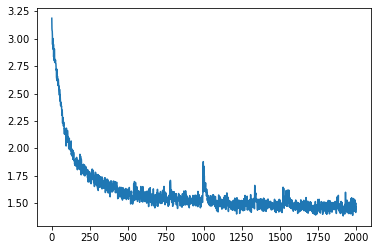

In [11]:
plt.plot(losses)

Plot the results

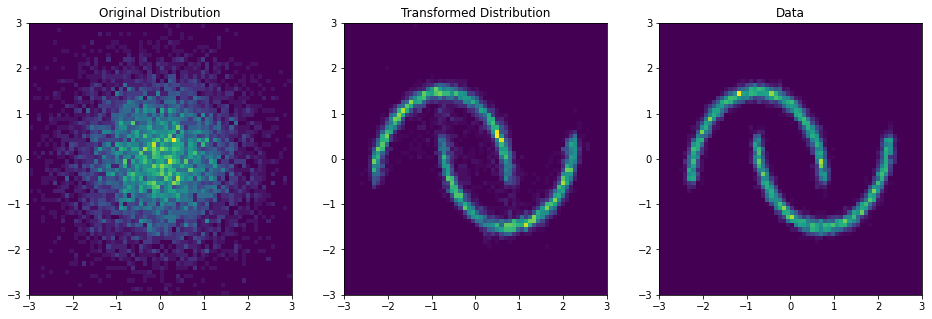

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5))

samps = tfd.Normal(0,1).sample((10000,2), seed=jax.random.PRNGKey(0))
ax1.hist2d(samps[:,0], samps[:,1], 64, range=[[-3,3],[-3,3]])
ax1.set_title("Original Distribution")

samps = flow.sample(10000)
ax2.hist2d(samps[:,0], samps[:,1], 64, range=[[-3,3],[-3,3]])
ax2.set_title("Transformed Distribution")

ax3.hist2d(x[0], x[1], 64, range=[[-3,3],[-3,3]])
ax3.set_title("Data")

plt.show()

## Hyperparameter optimization with Hyperopt

Now I will test searching the hyperparameter space using [hyperopt](https://hyperopt.github.io/hyperopt/). Here is an extensive [tutorial](https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt) (I have only skimmed it so far).

You can parallelize the optimization, but I haven't looked into that yet. There is some info on that [here](https://blog.goodaudience.com/on-using-hyperopt-advanced-machine-learning-a2dde2ccece7).

In [13]:
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

First split the data set into a training and test set. We will train the flows on the training set, but compare different hyperparameter choices by evaluating the loss on the test set.

In [14]:
trainingset, testset = train_test_split(x, train_size=0.8, random_state=0)

Now the objective function to minimize. It takes a set of hyperparameters, creates a flow, trains it on the training set, then evaluates the loss on the test set. The function returns a dictionary that contains the loss, the corresponding trained flow, and a status indicator which is required by hyperopt when returning a dictionary.

In [15]:
def objective(hyperparams):
    
    flow = NormalizingFlow(RQNeuralSplineFlow, hyperparams)
    flow.train(trainingset)
    loss = -np.mean(flow.log_prob(testset))
    
    return {'loss' : loss, 'flow' : flow, 'status': STATUS_OK}

Now define the space of hyperparameters to search (documentation [here](https://github.com/hyperopt/hyperopt/wiki/FMin)). Hyperopt allows you to build complicated, nested hyperparameter spaces, but for this test I do a small, simple search. The aim isn't to find the best hyperparameters, just to test hyperopt.

In [16]:
space = {'nfeatures' : 2,
         'nlayers' : 2 + hp.randint('nlayers', 2),
         'nbins' : 20 + hp.randint('nbins', 16),
         'cf_range_max' : 1,
         'cf_dim' : 128,
         'cf_layers' : 2}

Finally, minimize the validation loss with respect to the hyperparameters (documentation [here](https://github.com/hyperopt/hyperopt/wiki/FMin)). The Trials object keeps track of the results for every step of the minimization. The search algorithm is a Tree-structured Parzen Estimator ([explanation here](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#tree-structured-parzen-estimators-tpe)).

In [17]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=4, trials=trials, rstate=np.random.seed(0))

100%|██████████| 4/4 [20:42<00:00, 310.56s/trial, best loss: 1.4182536602020264]


Here are the hyperparameters with the best validation loss.

In [18]:
space_eval(space, best)

{'cf_dim': 128,
 'cf_layers': 2,
 'cf_range_max': 1,
 'nbins': 27,
 'nfeatures': 2,
 'nlayers': 3}

Plot the results

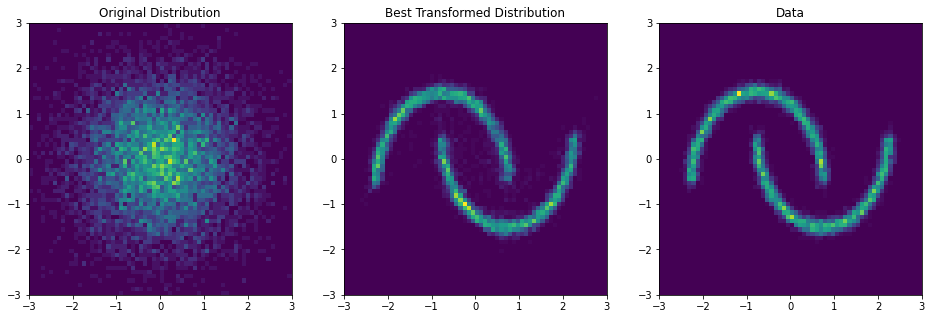

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5))

samps = tfd.Normal(0,1).sample((10000,2), seed=jax.random.PRNGKey(0))
ax1.hist2d(samps[:,0], samps[:,1], 64, range=[[-3,3],[-3,3]])
ax1.set_title("Original Distribution")

samps = trials.best_trial['result']['flow'].sample(10000)
ax2.hist2d(samps[:,0], samps[:,1], 64, range=[[-3,3],[-3,3]])
ax2.set_title("Best Transformed Distribution")

ax3.hist2d(x[0], x[1], 64, range=[[-3,3],[-3,3]])
ax3.set_title("Data")

plt.show()